#### Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from yellowbrick.regressor import ResidualsPlot
from featurewiz import FeatureWiz
from sklearn.ensemble import RandomForestRegressor
import shap
import xgboost

Imported 0.2.03 version. Select nrows to a small number when running on huge datasets.
output = featurewiz(dataname, target, corr_limit=0.90, verbose=2, sep=',', 
		header=0, test_data='',feature_engg='', category_encoders='',
		dask_xgboost_flag=False, nrows=None, skip_sulov=False)
Create new features via 'feature_engg' flag : ['interactions','groupby','target']



#### Config

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)}) # set global plot size
palette = sns.color_palette("flare") # set color palette
warnings.filterwarnings('ignore') # ignore warnings for plotting

#### Load Data

In [3]:
df = pd.read_excel('DataScientistTask_Dataset.xlsx')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9206 entries, 0 to 9205
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   WellID              9206 non-null   int64  
 1   BVHH                7565 non-null   float64
 2   FormationAlias      9206 non-null   object 
 3   NioGOR              8709 non-null   float64
 4   CodGOR              7538 non-null   float64
 5   LateralLength       9206 non-null   float64
 6   ProppantPerFoot     8974 non-null   float64
 7   FluidPerFoot        8942 non-null   float64
 8   LeftDistance        6758 non-null   float64
 9   LeftNeighbourType   9206 non-null   object 
 10  RightDistance       6778 non-null   float64
 11  RightNeighbourType  9206 non-null   object 
 12  TVD                 8893 non-null   float64
 13  NormalizedOilEUR    9206 non-null   float64
 14  NormalizedGasEUR    9206 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 1.1+ 

#### Data Preperation

In [5]:
df.isnull().sum()

WellID                   0
BVHH                  1641
FormationAlias           0
NioGOR                 497
CodGOR                1668
LateralLength            0
ProppantPerFoot        232
FluidPerFoot           264
LeftDistance          2448
LeftNeighbourType        0
RightDistance         2428
RightNeighbourType       0
TVD                    313
NormalizedOilEUR         0
NormalizedGasEUR         0
dtype: int64

<AxesSubplot:>

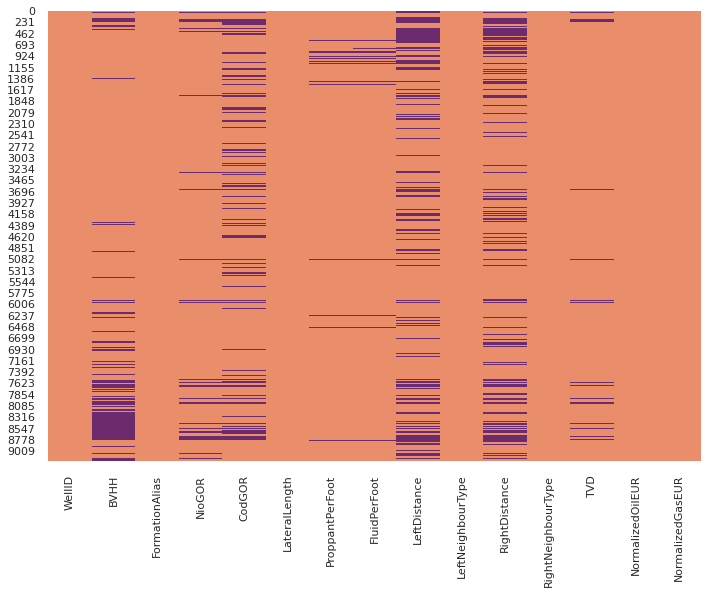

In [6]:
mask = df.isnull()
sns.heatmap(mask, cbar=False, cmap=palette)

Checking nulls for left/right distances when `Neighbour Type` exists

In [7]:
df['LeftNeighbourType'].value_counts()

Codeveloped    6046
NoNeighbour    2448
Parent          712
Name: LeftNeighbourType, dtype: int64

In [8]:
df[df['LeftNeighbourType'] != 'NoNeighbour']['LeftDistance'].isnull().sum()

0

In [9]:
df[df['RightNeighbourType'] != 'NoNeighbour']['RightDistance'].isnull().sum()

0

The distances is calculated as `Null` only when there's no neighbour well around, so will fill it with `-1` 

In [10]:
df['LeftDistance'].fillna(-1, inplace = True)
df['RightDistance'].fillna(-1, inplace = True)

Seperating `categorical` and `numerical` features to show distributions

In [11]:
categorical_df = df.select_dtypes(include='object')
numerical_df = df.select_dtypes(include = 'float64')

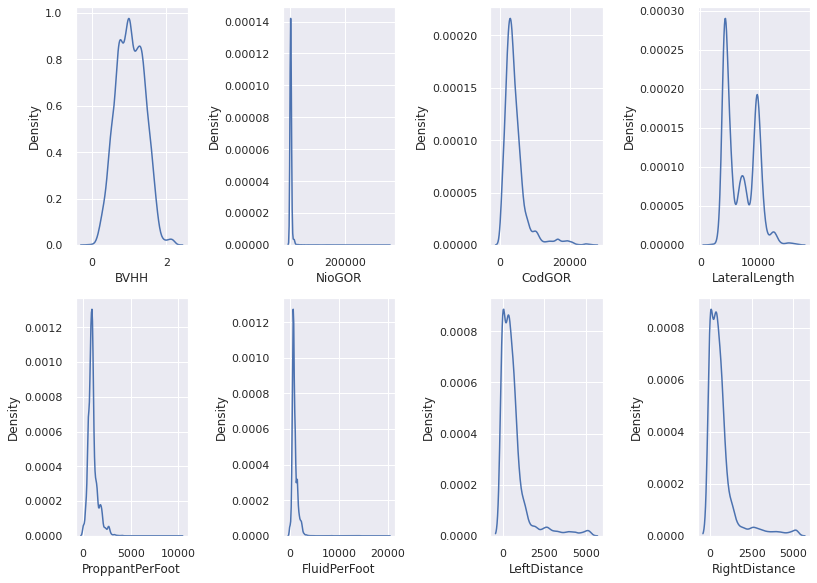

In [12]:
fig, axes = plt.subplots(ncols=4, nrows=2)

for col, ax in zip(numerical_df.columns, axes.flat):
    sns.distplot(df[col], hist=False, ax=ax)
plt.tight_layout()
plt.show()

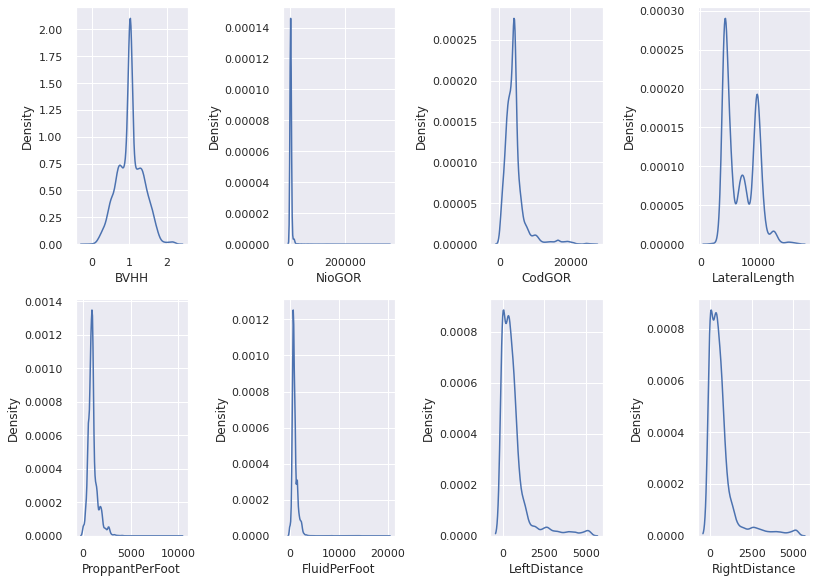

In [13]:
fig, axes = plt.subplots(ncols=4, nrows=2)

for col, ax in zip(numerical_df.columns, axes.flat):
    sns.distplot(df[col].fillna(numerical_df[col].mean()), hist=False, ax=ax)
plt.tight_layout()
plt.show()

The above 2 subplots explain the different in features distributions before and after imputing the nulls with `mean`

Observations:
- `BVHH` the distribution is more narrowed, resulting a lower bias when imputing with means
- `NioGOR` and `CodGOR` became more narrow with same skewness to the left
- `ProppantPerFoot` and `FluidPerFoot` no noticeable difference

For the numerical values, will impute the nulls with the mean

In [14]:
[df[col].fillna(df[col].mean(), inplace = True) for col in numerical_df.columns]

[None, None, None, None, None, None, None, None, None, None, None]

Checking for categorical variables

In [15]:
categorical_df.isnull().sum()

FormationAlias        0
LeftNeighbourType     0
RightNeighbourType    0
dtype: int64

#### EDA

Generating Correlations Heatmap

<AxesSubplot:>

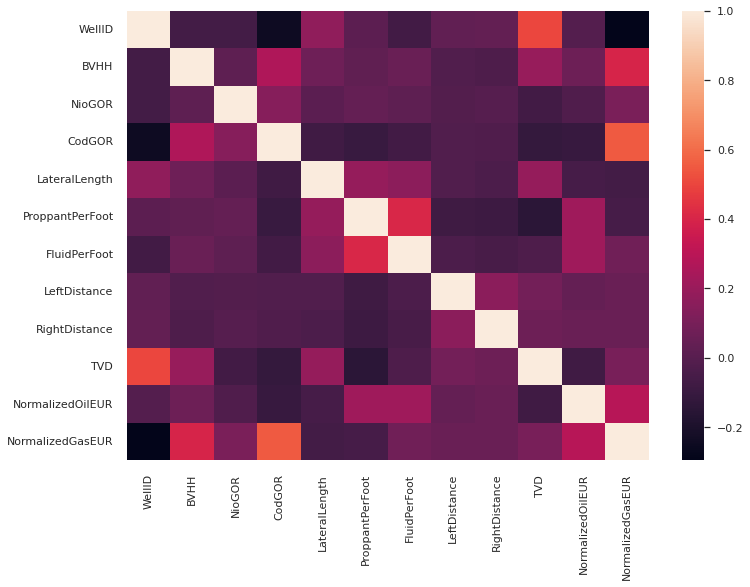

In [16]:
corr = df.corr()
sns.heatmap(corr)

Seem there's a strong correlation (interaction) between numerical variables that might result into bad interpitability after we apply the data modelling. Let's check for co-linearity first.

Plotting pair plots between the variables:

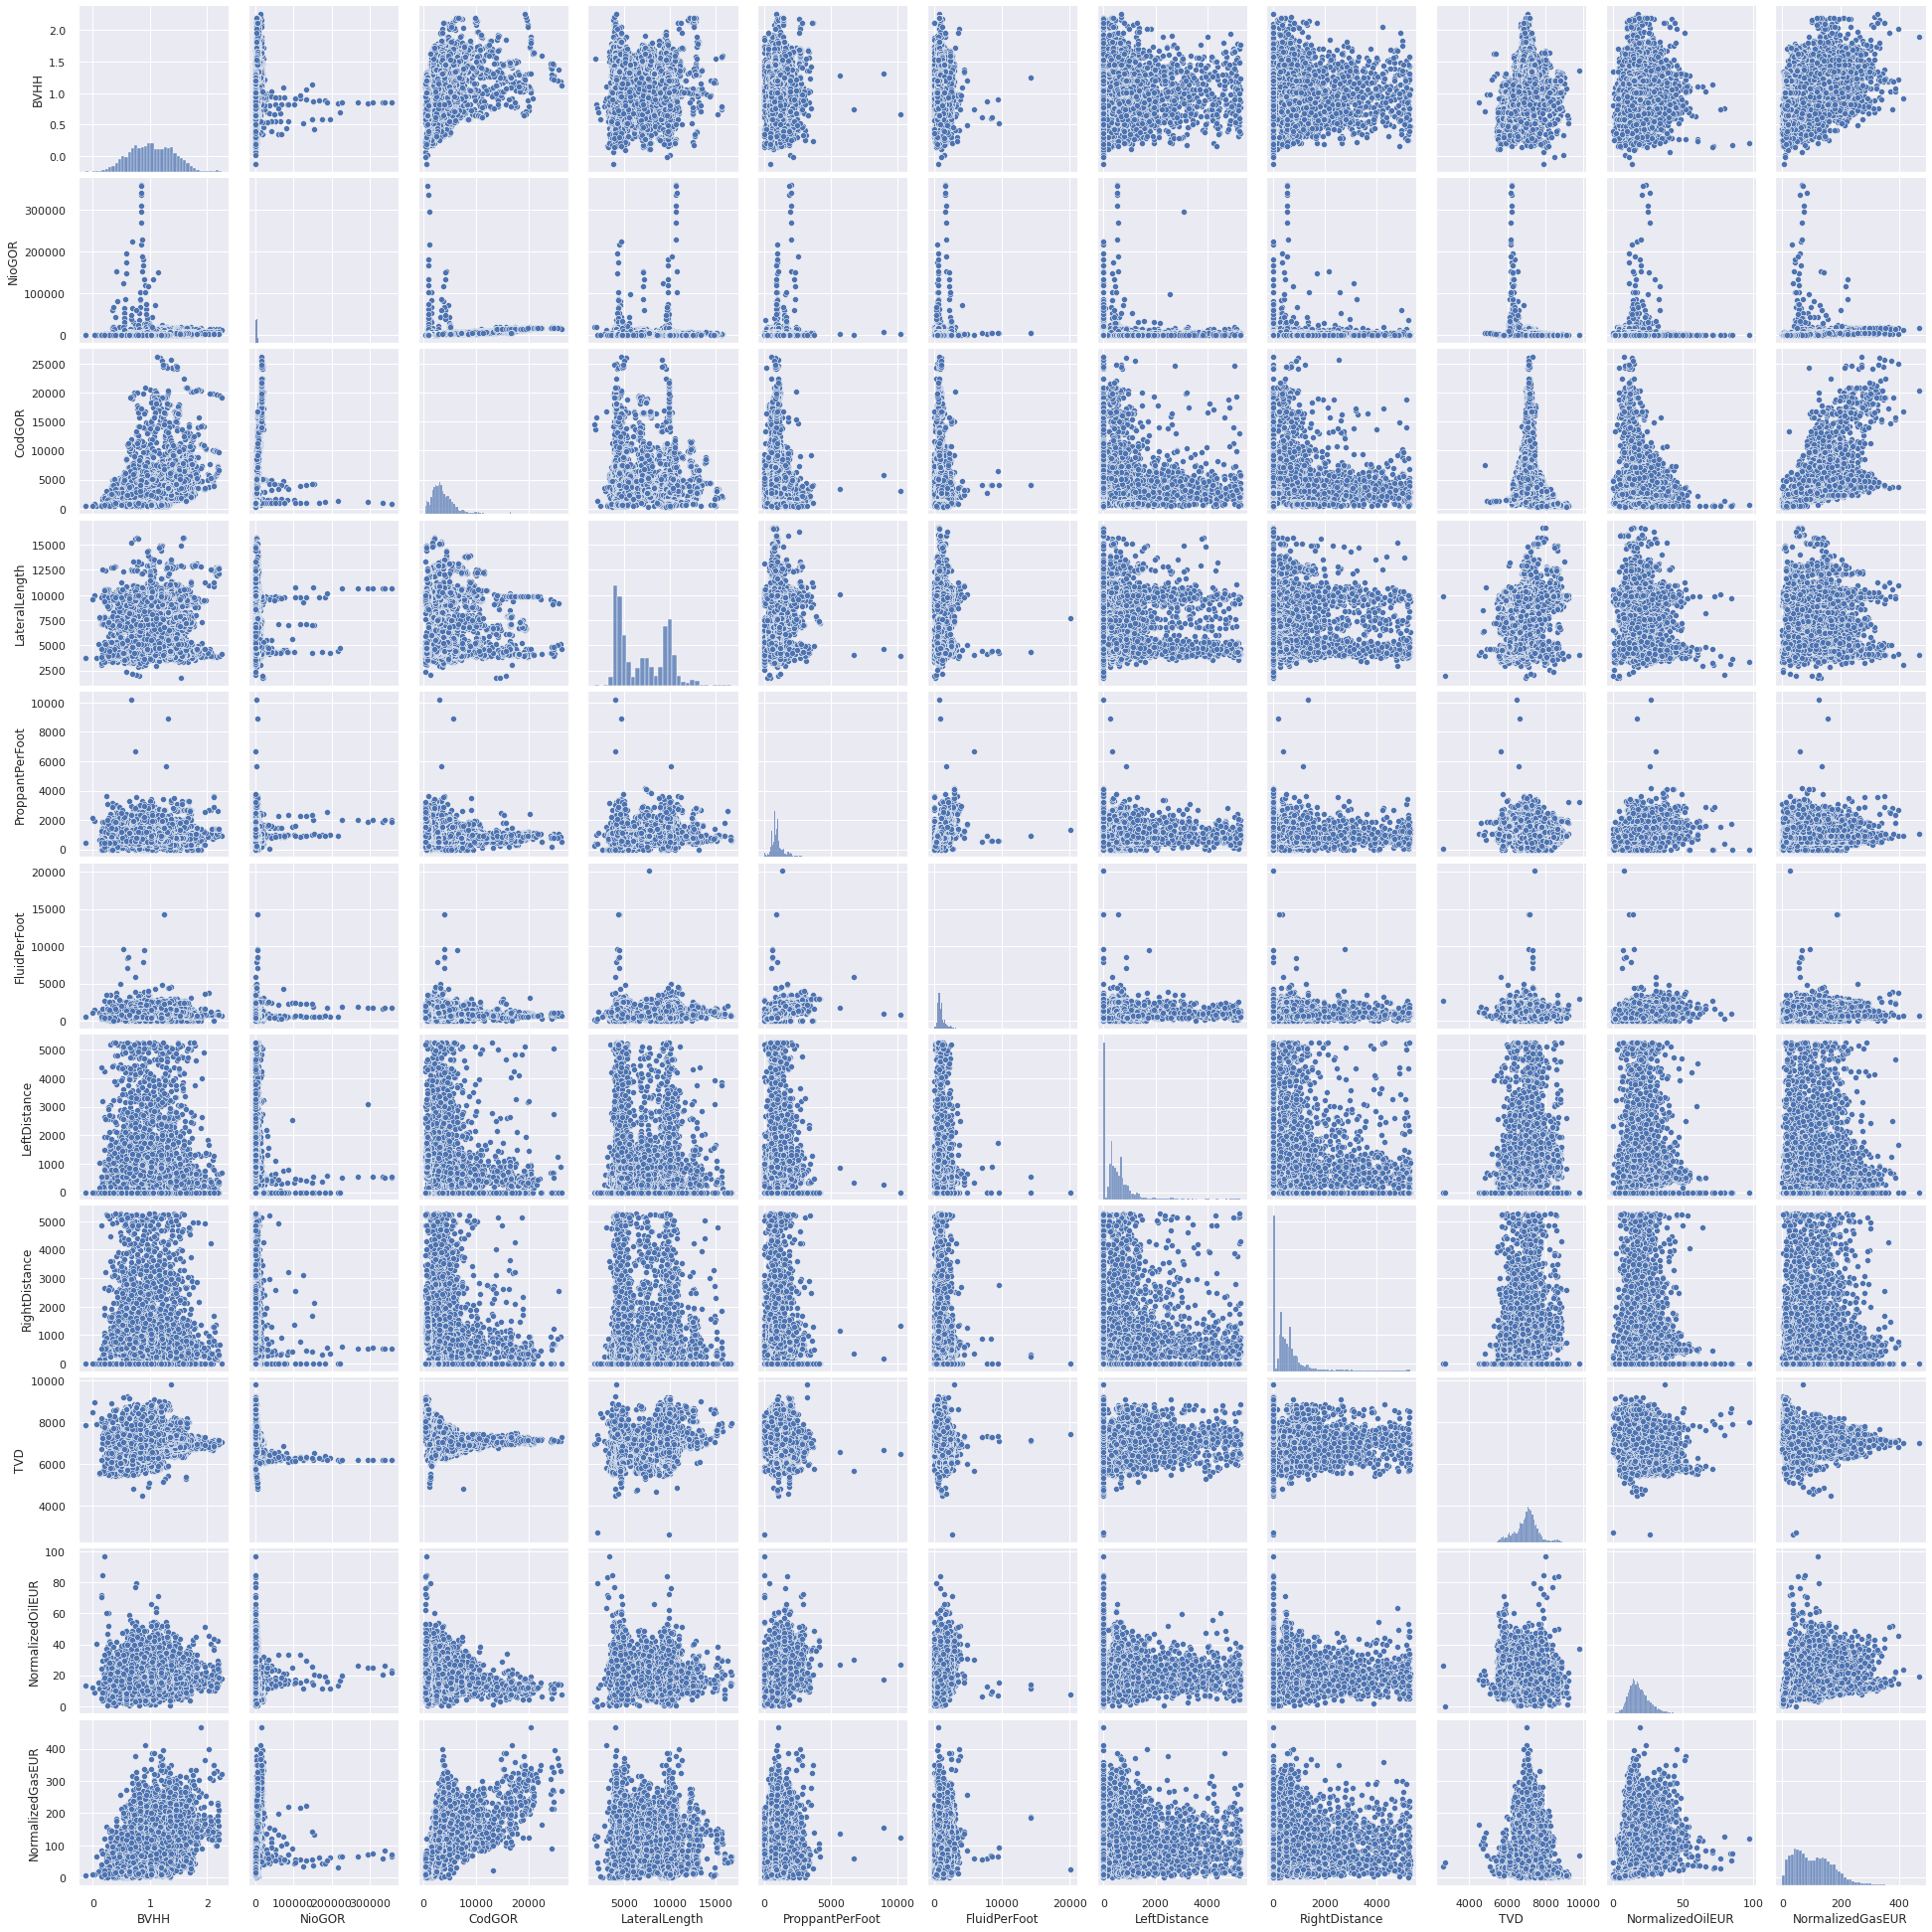

In [17]:
sns.pairplot(numerical_df)

Thankfully, the pair plots showed no colinearity between numerical features, except for `TVD` and `Lateral Length`, as both of them represent the depth of the well, will get fed to the model seperatly

We can spot a correlation between `BVHH` and Gas Amount, which has the smallest range of values, to reduce model's bias toward large values.

We will apply `Z-Score Normalization` to our features, to mitigate the higher covariance effects on our linear model

#### Data Processing

In [17]:
scaler = StandardScaler()
numerical_data =scaler.fit_transform(df[numerical_df.columns])
numerical_columns = numerical_df.columns

Checking number of categories in `categorical_df` to decide which type of encoding to follow

In [18]:
categorical_df.nunique().sum()

8

8 is reasonable, won't produce a highly sparce dataframe, in addition to being non-ordinal, so we are going with the vanilla one-hot encoding

In [19]:
encoder = OneHotEncoder(sparse=False)
categorical_data = encoder.fit_transform(df[categorical_df.columns])
categorical_columns = encoder.get_feature_names(categorical_df.columns)

In [20]:
transformed_df = pd.concat([
    pd.DataFrame(categorical_data, columns=categorical_columns),
    pd.DataFrame(numerical_data, columns=numerical_columns)
], axis=1)

In [21]:
# To test the model without scaling numerical features
df.drop(categorical_df.columns, axis = 1, inplace= True)
df[categorical_columns] = categorical_data

### Data Modelling

We will divide them into 2 seperate models, as there's a huge collinearity between the amount of gas and amount of oil variables 

We will start with regression for interpretability reasons, starting with linear then moving into polynomial approach

#### Feature Engineering

In [22]:
X = transformed_df.drop(["NormalizedOilEUR", "NormalizedGasEUR"], axis=1)
y_oil, y_gas = transformed_df["NormalizedOilEUR"],  transformed_df["NormalizedGasEUR"]

Starting with linear model to capture the relations between features `X` and oil `y_oil`

In [23]:
X_train_oil, X_test_oil, y_train_oil, y_test_oil = train_test_split(X, y_oil, test_size=0.2, random_state=777)

Using FeatureWiz we can determine the most important features for our regressions model, using iterative `XGBoost`

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (7364, 18)
#### Single_Label Regression problem ####
No test data filename given...
####################################################################################

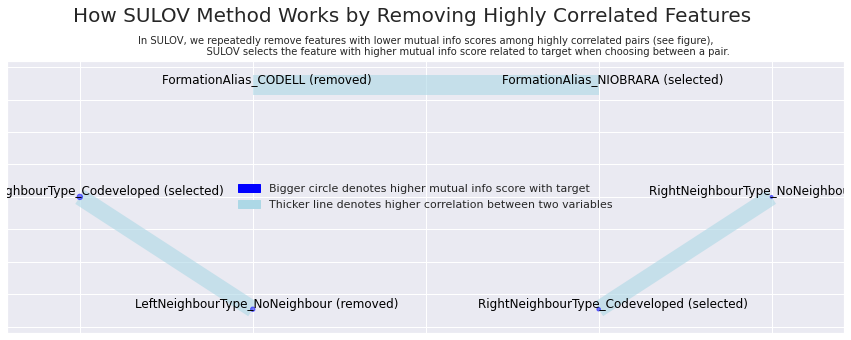

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 14
Final list of selected 14 vars after SULOV = ['BVHH', 'CodGOR', 'FluidPerFoot', 'LateralLength', 'LeftDistance', 'LeftNeighbourType_Parent', 'NioGOR', 'ProppantPerFoot', 'RightDistance', 'RightNeighbourType_Parent', 'TVD', 'LeftNeighbourType_Codeveloped', 'RightNeighbourType_Codeveloped', 'FormationAlias_NIOBRARA']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 14 
    Taking top 4 features per iteration...
    XGBoost version using 1.7.2 as tree method: hist
Number of booster rounds = 100
        using 14 variables...
 

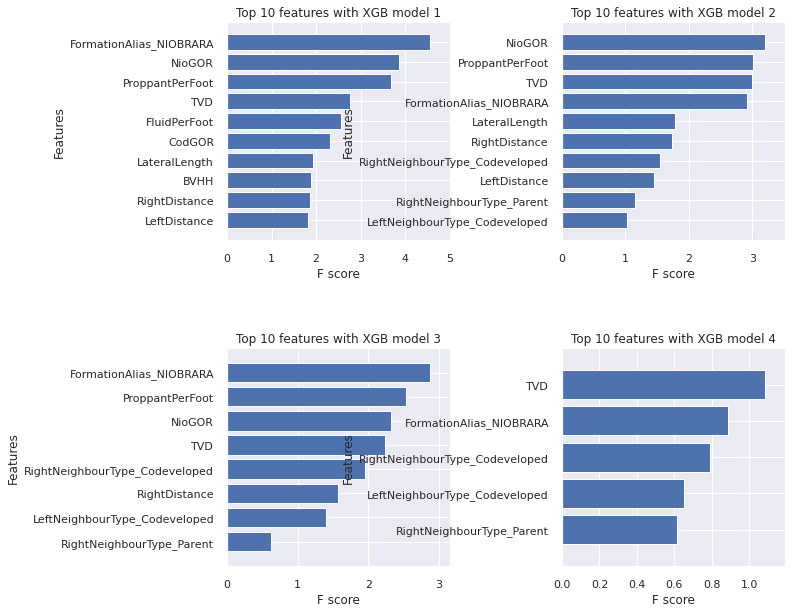

    Completed XGBoost feature selection in 0 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 7 important features:
['FormationAlias_NIOBRARA', 'NioGOR', 'ProppantPerFoot', 'TVD', 'FluidPerFoot', 'CodGOR', 'LateralLength']
Total Time taken for featurewiz selection = 1 seconds
Output contains a list of 7 important features and a train dataframe
    Time taken to create entire pipeline = 1 second(s)


['FormationAlias_NIOBRARA',
 'NioGOR',
 'ProppantPerFoot',
 'TVD',
 'FluidPerFoot',
 'CodGOR',
 'LateralLength']

In [24]:
features_oil = FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected_oil = features_oil.fit_transform(X_train_oil, y_train_oil)
X_test_selected_oil = features_oil.transform(X_test_oil)
features_oil.features 

In [25]:
X_train_gas, X_test_gas, y_train_gas, y_test_gas = train_test_split(X, y_gas, test_size=0.2, random_state=777)

wiz = FeatureWiz(verbose=1)
        X_train_selected = wiz.fit_transform(X_train, y_train)
        X_test_selected = wiz.transform(X_test)
        wiz.features  ### provides a list of selected features ###            
        
############################################################################################
############       F A S T   F E A T U R E  E N G G    A N D    S E L E C T I O N ! ########
# Be judicious with featurewiz. Don't use it to create too many un-interpretable features! #
############################################################################################
Correlation Limit = 0.7
Skipping feature engineering since no feature_engg input...
Skipping category encoding since no category encoders specified in input...
#### Single_Label Regression problem ####
    Loaded train data. Shape = (7364, 18)
#### Single_Label Regression problem ####
No test data filename given...
####################################################################################

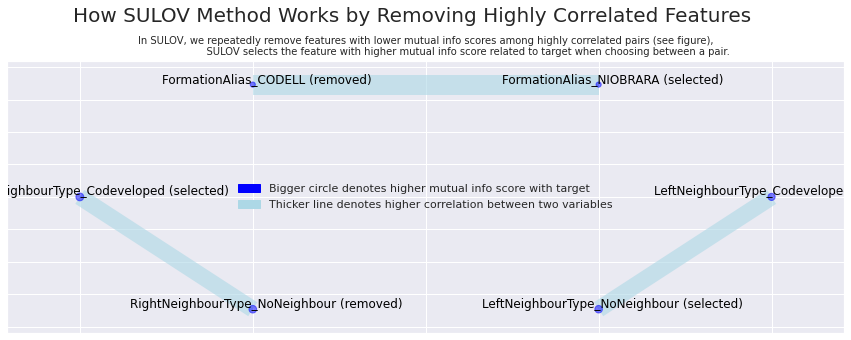

Time taken for SULOV method = 0 seconds
    Adding 0 categorical variables to reduced numeric variables  of 14
Final list of selected 14 vars after SULOV = ['BVHH', 'CodGOR', 'FluidPerFoot', 'LateralLength', 'LeftDistance', 'LeftNeighbourType_Parent', 'NioGOR', 'ProppantPerFoot', 'RightDistance', 'RightNeighbourType_Parent', 'TVD', 'RightNeighbourType_Codeveloped', 'LeftNeighbourType_NoNeighbour', 'FormationAlias_NIOBRARA']
Converting all features to numeric before sending to XGBoost...
#######################################################################################
#####    R E C U R S I V E   X G B O O S T : F E A T U R E   S E L E C T I O N  #######
#######################################################################################
    using regular XGBoost
Current number of predictors before recursive XGBoost = 14 
    Taking top 4 features per iteration...
    XGBoost version using 1.7.2 as tree method: hist
Number of booster rounds = 100
        using 14 variables...
 

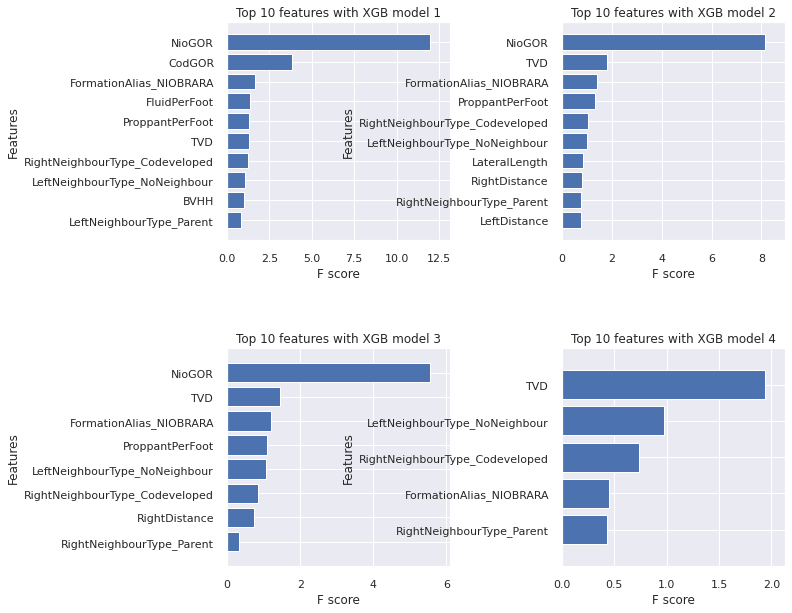

    Completed XGBoost feature selection in 0 seconds
#######################################################################################
#####          F E A T U R E   S E L E C T I O N   C O M P L E T E D            #######
#######################################################################################
Selected 5 important features:
['NioGOR', 'CodGOR', 'FormationAlias_NIOBRARA', 'FluidPerFoot', 'TVD']
Total Time taken for featurewiz selection = 1 seconds
Output contains a list of 5 important features and a train dataframe
    Time taken to create entire pipeline = 1 second(s)


['NioGOR', 'CodGOR', 'FormationAlias_NIOBRARA', 'FluidPerFoot', 'TVD']

In [26]:
features_gas = FeatureWiz(corr_limit=0.70, feature_engg='', category_encoders='', dask_xgboost_flag=False, nrows=None, verbose=2)
X_train_selected_gas = features_gas.fit_transform(X_train_gas, y_train_gas)
X_test_selected_gas = features_gas.transform(X_test_gas)
features_gas.features 

#### Linear Regression

In [27]:
model_oil = LinearRegression()
model_oil.fit(X_train_selected_oil, y_train_oil)

LinearRegression()

In [28]:
y_pred_oil = model_oil.predict(X_test_selected_oil)
mae = mean_absolute_error(y_test_oil, y_pred_oil)
mse = mean_squared_error(y_test_oil, y_pred_oil)
r2 = r2_score(y_test_oil, y_pred_oil)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.70
MSE: 0.91
R2: 0.06


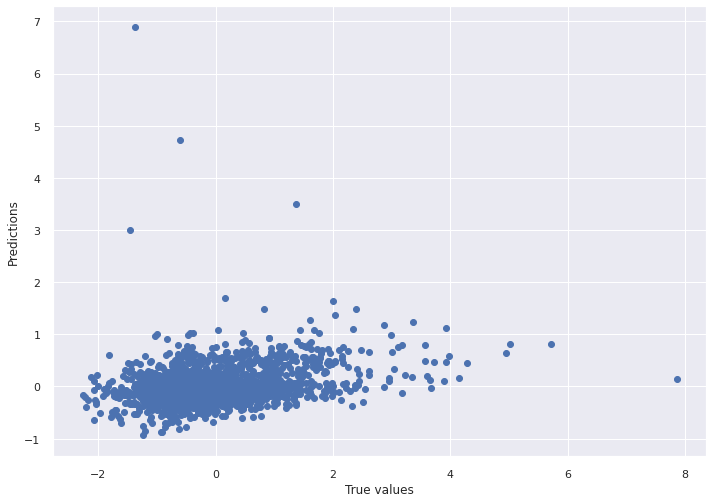

In [29]:
plt.scatter(y_test_oil, y_pred_oil)
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.show()

Then plotting the residuals to highlight the difference in distributions and outliers

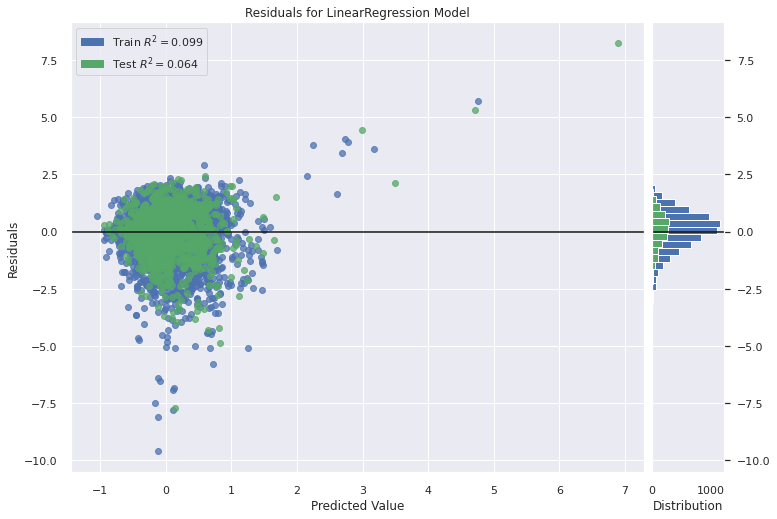

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [30]:
visualizer = ResidualsPlot(model_oil)

visualizer.fit(X_train_selected_oil, y_train_oil)  
visualizer.score(X_test_selected_oil, y_test_oil) 
visualizer.show()

From the figure above, the predicted values got a nearby distribution for the actual values

Now repeating the same steps for the amount of gas, `NormalizedGasEUR`

In [31]:
model_gas = LinearRegression()
model_gas.fit(X_train_selected_gas, y_train_gas)

LinearRegression()

In [32]:
y_pred_gas = model_gas.predict(X_test_selected_gas)
mae = mean_absolute_error(y_test_gas, y_pred_gas)
mse = mean_squared_error(y_test_gas, y_pred_gas)
r2 = r2_score(y_test_gas, y_pred_gas)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.65
MSE: 0.68
R2: 0.35


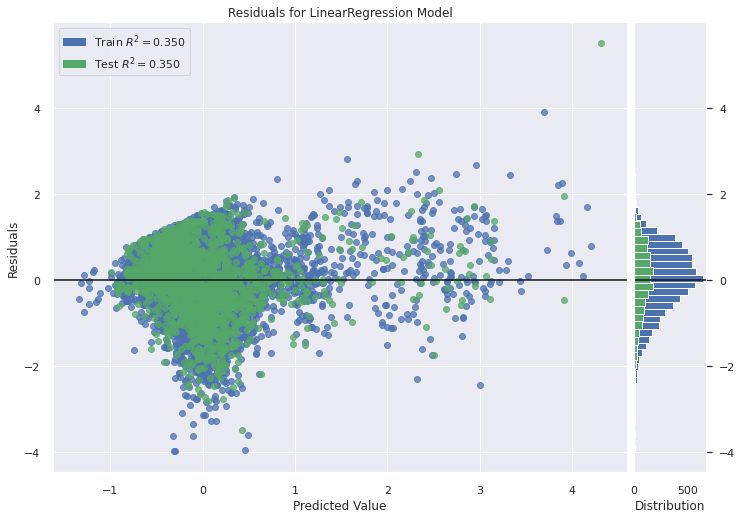

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [33]:
visualizer = ResidualsPlot(model_gas)

visualizer.fit(X_train_selected_gas, y_train_gas)  
visualizer.score(X_test_selected_gas, y_test_gas) 
visualizer.show()

The residual plot shows a much better distribution than the oil model, which was concluded from the pair plot between features and target

Nevertheless, the results in terms of $R^2$ are not satisifactory, meaning the model could not capture the relationship between predictors and target variable correctly, due to the lack of linear correlations between predictors and the targets

So we will pick another model, Random Forest, with another technique called **SHAP Analysis** to help with interpretability and illusterating the effects on our model

#### SHAP Analysis

SHAP analysis a method for explaining the output of a machine learning model. It does this by identifying the features (input variables) that contribute most to the prediction made by the model, and estimating the importance of each feature. For more insights regarding the concept: https://www.nature.com/articles/s42256-019-0138-9

We will conduct the shap analysis all features of the `transformed_df` and using a Random Forest Regressor to benift of the bagging technique, which leads to higher confidence in our selection.

In [34]:
model_oil = RandomForestRegressor()
model_oil.fit(X_train_oil, y_train_oil)

RandomForestRegressor()

In [39]:
y_pred_oil = model_oil.predict(X_test_oil)
mae = mean_absolute_error(y_test_oil, y_pred_oil)
mse = mean_squared_error(y_test_oil, y_pred_oil)
r2 = r2_score(y_test_oil, y_pred_oil)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.48
MSE: 0.50
R2: 0.49


The Random Tree regression resulted $31%$ higher MAE than the Linear model

In [35]:
explainer_oil = shap.Explainer(model_oil.predict, X_test_oil)
shap_values_oil = explainer_oil(X_test_oil)

Permutation explainer: 1843it [07:43,  3.90it/s]                                                                        


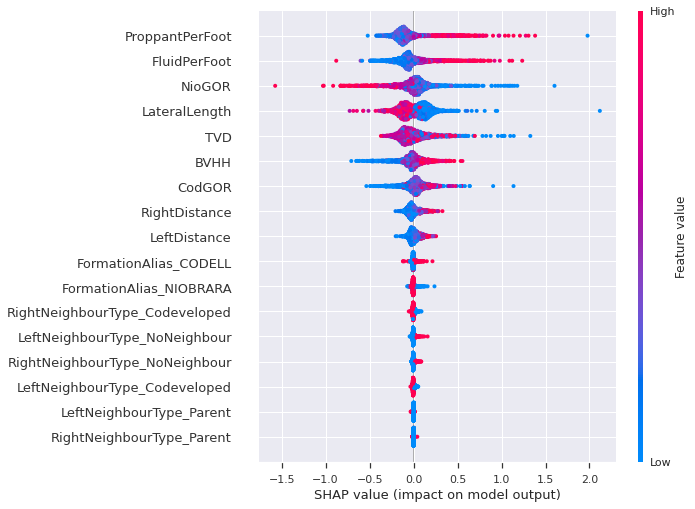

In [36]:
shap.summary_plot(shap_values_oil)

The above graph explains the relationship between each features effect on the model's prediction. For example, high values of `ProppantPerFoot` has the highest impact on the model, especially the high range of  these values.

The graph also shows how the neighbours distances did not contribute as much for the amount of oil produced by the well. And interestengly, the well's length affected the model's output by the same amount by the high and low lengths.

The only natural features are `NioGOR`, `CodGOR`, and `BVHH`. The first twos explain the ratio of Oil/Gas in different geological formations. The last attributes to the quality of rocks in the drilling area. 

In [43]:
model_gas = RandomForestRegressor()
model_gas.fit(X_train_gas, y_train_gas)

RandomForestRegressor()

In [46]:
explainer_gas = shap.Explainer(model_gas.predict, X_test_gas)
shap_values_gas = explainer_gas(X_test_gas)

Permutation explainer: 1843it [07:22,  4.07it/s]                                                                        


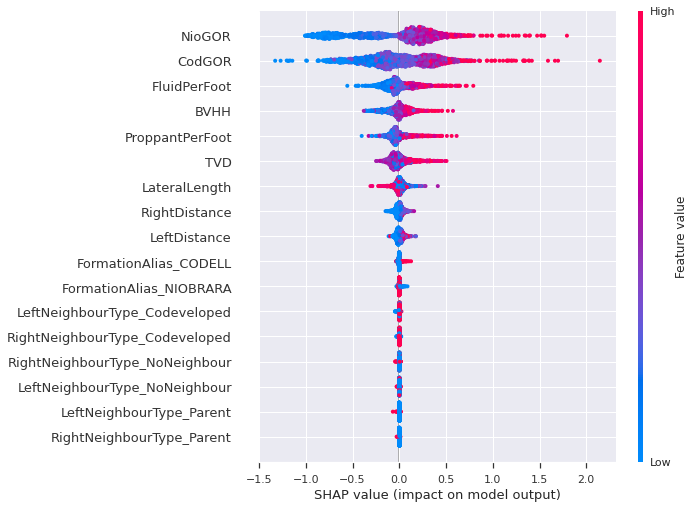

In [47]:
shap.summary_plot(shap_values_gas)

The graph also shows how the neighbours distances did not contribute as much for the amount of oil produced by the well as for its companion (oil model). But this time, the ratios between gas/oil in the rock formations, highly contributed in the model's output especially with high ratios.

#### Conclusion

The SHAP analysis illustrated the featute importance used for oil and gas models. The drilling-related features (e.g. length of the well, the amounts of proppant) affected the oil amount more than gas, on the contrary, the gelogical features (e.g. ratios of oil/gas in the gelogical formations beneath the wells) had a more significant impact on the gas model 